Estimate parameters for resampling procedure (trial generation).

* Number of resampling iterations: M is based on bootstrapping stability analysis 
* Number of trials per resampling: N = 40 (based on data in monkey dataset so the number of trials is from experiments)

#### Bootstrapping Stability Analysis (for M)

We determine a reasonable M by checking when the median stabilizes (using median because IT distribution is skewed):

1. Compute the median and the sem equivalent for median (using MAD - median absolute deviation) of intrinsic timescales as M increases.
2. Plot the standard error of the median vs. M.
3. Pick M where SE and its 95% confidence interval are under 25ms.

Run for M = [50, 100, 200, 500, 1000]

#### Selecting number of signals for M estimate

Spike trains are coming from different brain areas and may have different variance so using only one is not gut. The total number of signals and the min per area number of signals are set. After sampling the min number per area the rest is sampled proportionally to the number of signals in the area.

Min number per area: 10
N total: 100 (97)

In [1]:
import csv
import sys
import pickle
import numpy as np
import pandas as pd
import random
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# import from scripts
import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
#os.chdir(os.path.abspath("C:\\Users\\ipoch\\Documents\\repos\\isttc\\scripts"))
from calculate_tau import fit_single_exp, func_single_exp_monkey
from cfg_global import project_folder_path
from calculate_acf import acf_pearsonr_trial_avg, acf_sttc_trial_avg, acf_sttc_trial_concat
from spike_train_utils import bin_spike_train_fixed_len, get_trials, bin_trials
os.chdir(current_wd)

In [2]:
dataset_folder = project_folder_path + 'results\\allen_mice\\dataset\\cut_30min\\'
fig_folder = project_folder_path + 'results\\allen_mice\\fig_draft_paper\\'

In [63]:
estimate_m = False
save_fig = True

### Get data

In [4]:
if estimate_m:
    csv_data_file = dataset_folder + 'sua_list_constrained.csv'
    with open(csv_data_file, newline='') as f:
        reader = csv.reader(f)
        sua_list = list(reader)
    print(f'Loaded N units {len(sua_list)}')

In [6]:
units_info_df = pd.read_pickle(dataset_folder + 'sua_list_constrained_units_df.pkl')
units_info_df.head(2)

,specimen_id,session_id,unit_id,ecephys_structure_acronym,firing_rate,amplitude_cutoff,isi_violations,presence_ratio,fr_hz_spont_30min,fr_hz_spont_30min_log10
66,744912849,766640955,950913540,VISam,5.924830,0.004951,0.157933,0.99,6.038333,0.780917
67,744912849,766640955,950915005,VISam,4.549072,0.001203,0.096072,0.99,4.030556,0.605365


### Estimate M

#### Run bootstrapping

In [ ]:
def sample_signals(units_df, min_per_area, n_total):
    sampled_units = []

    area_counts = units_df["ecephys_structure_acronym"].value_counts()
    base_samples = {area: min(min_per_area, count) for area, count in area_counts.items()}
    remaining_samples = n_total - sum(base_samples.values())
    total_remaining = sum(area_counts) - sum(base_samples.values())
    print(f'total {n_total}, min per area {min_per_area}. Base samples {base_samples}, \nproportional samples {remaining_samples}')
    
    # get min_per_area, then sample proportionally
    for area, count in area_counts.items():
        base_samples = min(min_per_area, count)
        extra_samples = int((count / total_remaining) * remaining_samples) if total_remaining > 0 else 0
        n_samples = base_samples + extra_samples
        sampled_units.extend(units_info_df[units_info_df["ecephys_structure_acronym"] == area]
                             .sample(n=min(n_samples, count), random_state=42)["unit_id"].tolist())
    
    return sampled_units

In [ ]:
if estimate_m:
    fs = 30000
    signal_len = int(30 * 60 * fs)
    n_lags = 20
    bin_size = 50 # in ms
    trial_len = int(n_lags * bin_size * (fs/1000))
    
    n_trials = 40 # this is fixed based on experimental datasets
    m_iterations = [20, 40, 60, 80, 100, 150, 200, 500, 1000]
    
    n_total_signals = 100
    min_signal_per_area = 10

In [ ]:
if estimate_m:
    units_to_sample = sample_signals(units_info_df, min_signal_per_area, n_total_signals)
    random_signals = [item for item in sua_list if item[2] in units_to_sample]
    
    output_log = dataset_folder + f'resampling//resampling_params_estimate_{n_signals}_signals.txt'
    old_stdout = sys.stdout
    sys.stdout = open(output_log, 'w')
    
    signal_tau_dict = {}
    
    for signal_idx, signal in enumerate(random_signals):
        print(f'###\nCalculating for {signal_idx} signal')
        spikes = np.asarray([int(spike) for spike in signal[8:]])
    
        tau_dict = {}
        for m_iteration in m_iterations:
            print(f'calculating for {m_iteration} resampling iterations')
            tau_l = []
            for m in range(m_iteration):
                spikes_trials = get_trials(spikes, signal_len, n_trials, trial_len, verbose_=False)
                spikes_trials_binned = bin_trials(spikes_trials, trial_len, int(bin_size*(fs/1000)))
                # get taus
                _, acf_average = acf_pearsonr_trial_avg(spikes_trials_binned, n_lags, verbose_=False)
                _, _, tau, _, _, _, _ = fit_single_exp(acf_average, start_idx_=1, exp_fun_=func_single_exp_monkey)
                tau_l.append(tau)
            tau_dict[m_iteration] = tau_l
            
        signal_tau_dict[signal[2]] = tau_dict
    
    with open(dataset_folder + f'resampling//signal_tau_dict_{n_signals}_signals.pkl', "wb") as f:
        pickle.dump(signal_tau_dict, f)
    
    sys.stdout = old_stdout

#### Find M

In [8]:
with open(dataset_folder + f'resampling//signal_tau_dict_100_signals.pkl', "rb") as f:
    signal_tau_dict = pickle.load(f)
signal_tau_dict.keys()
print(f'N signals {len(signal_tau_dict)}')

N signals 97


In [24]:
signal_l = []
m_iterations_l = []
# tau_nanmean_l = []
# sem_tau_l = []
tau_nanmedian_l = []
sem_tau_median_l = []

for k, v in signal_tau_dict.items():
    for kk, vv in v.items():
        vv_nan_removed = [x for x in vv if not np.isnan(x)]
        if len(vv_nan_removed) < 1:
            print(len(vv_nan_removed))
            tau_med = np.nan
            tau_sem_median = np.nan
        # # mean based 
        # tau_mean = np.mean(vv_nan_removed)
        # tau_sem = stats.sem(vv_nan_removed)  
        # median based
        else:
            tau_med = np.nanmedian(vv_nan_removed)
            tau_mad = np.nanmedian(np.abs(vv_nan_removed - tau_med)) # median absolute deviation
            tau_sem_median = (1.4826 * tau_mad) / np.sqrt(len(vv_nan_removed)) # sem of sorts
        
        signal_l.append(k)
        m_iterations_l.append(kk)
        # tau_nanmean_l.append(tau_mean)
        # sem_tau_l.append(tau_sem)
        tau_nanmedian_l.append(tau_med)
        sem_tau_median_l.append(tau_sem_median)

# Create tau_df
tau_df = pd.DataFrame({
    "signal": signal_l,
    "m_iterations": m_iterations_l,
    # "tau_nanmean": tau_nanmean_l,
    # 'tau_sem': sem_tau_l,
    "tau_nanmedian": tau_nanmedian_l,
    'tau_sem_median': sem_tau_median_l
})
# tau_df['tau_sem_ms'] = tau_df['tau_sem'] * 50
tau_df['tau_sem_median_ms'] = tau_df['tau_sem_median'] * 50

# Check the stabilization of SE
threshold = 25 # ms
stabilization_list = []

for signal in tau_df["signal"].unique():
    signal_data = tau_df.query('signal == @signal').sort_values(by='m_iterations')
    sem_tau_values = signal_data['tau_sem_median_ms'].values
    m_iterations_values = signal_data['m_iterations'].values
    
    stabilization_point = np.nan  # Default to NaN if no stabilization is found
    for i in range(1, len(sem_tau_values)):
        if sem_tau_values[i] <= threshold:
            stabilization_point = m_iterations_values[i]
            break
    stabilization_list.append({"signal": signal, "stabilization_point": stabilization_point})

# Create stabilization_df
stabilization_df = pd.DataFrame(stabilization_list)

# add info about brain area
units_info_df_subset = units_info_df[['unit_id', 'ecephys_structure_acronym']].copy()

tau_df.rename(columns={'signal':'unit_id'}, inplace=True)
tau_df = pd.merge(tau_df, units_info_df_subset, on='unit_id', how='left')

stabilization_df.rename(columns={'signal':'unit_id'}, inplace=True)
stabilization_df = pd.merge(stabilization_df, units_info_df_subset, on='unit_id', how='left')

0
0
0
0


In [26]:
tau_df.head(2)

,unit_id,m_iterations,tau_nanmedian,tau_sem_median,tau_sem_median_ms,ecephys_structure_acronym
0,950914624,50,1.584250,0.365413,18.270635,VISam
1,950914624,100,1.963552,0.323083,16.154140,VISam


C:\Users\ipochino\AppData\Local\Temp\ipykernel_21220\1402315003.py:7: UserWarning: 
The palette list has fewer values (1) than needed (97) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(ax=axes[0], data=tau_df, x="m_iterations", hue='unit_id', y="tau_sem_median_ms", palette=['slategray'], lw=0.5, legend=False)


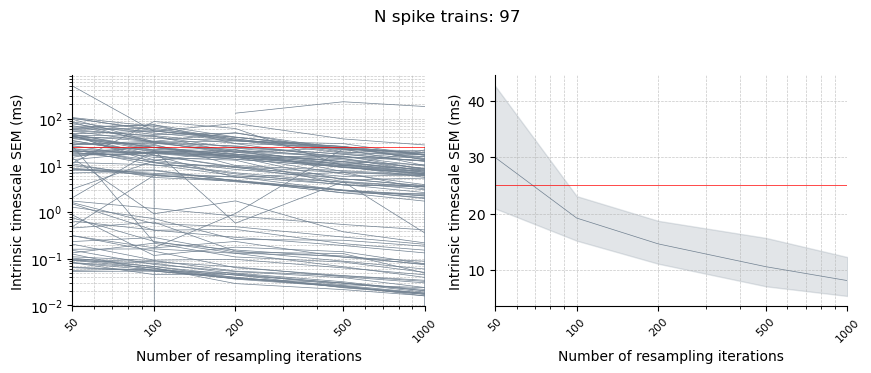

In [65]:
# m_iterations_x_axes = [20, 40, 60, 80, 100, 150, 200, 500, 1000]
# 2nd plot 95% CI
m_iterations_x_axes = [50, 100, 200, 500, 1000]

fig, axes = plt.subplots(1,2,figsize=(10,3))

sns.lineplot(ax=axes[0], data=tau_df, x="m_iterations", hue='unit_id', y="tau_sem_median_ms", palette=['slategray'], lw=0.5, legend=False)
axes[0].set_yscale('log')

sns.lineplot(ax=axes[1], data=tau_df, x="m_iterations", y="tau_sem_median_ms", color='slategray', lw=0.5, legend=False)

#sns.lineplot(ax=axes[2], data=tau_df, x="m_iterations", y="tau_sem_median_ms", hue='ecephys_structure_acronym', lw=0.5, legend=False)

fig.suptitle(f'N spike trains: {len(stabilization_df)}', y=1.1)

for ax in axes.flat:
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
    ax.set_xscale('log')
    ax.set_xticks(m_iterations_x_axes)
    ax.set_xticklabels(m_iterations_x_axes, rotation=45, fontsize=8)
    ax.set_xlim([50, 1000])
    ax.set_xlabel('Number of resampling iterations')
    ax.set_ylabel('Intrinsic timescale SEM (ms)')
    ax.axhline(y=25, lw=0.5, color='red')

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'n_iterations_vs_sem.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'n_iterations_vs_sem.svg' , bbox_inches='tight')

In [31]:
n_signals = len(stabilization_df)
n_signals_below_l = []
for n_iterations in m_iterations_x_axes:
    n_signals_below = len(stabilization_df.query('stabilization_point <= @n_iterations'))
    n_signals_below_l.append(n_signals_below/n_signals * 100)

stab_below_df = pd.DataFrame({
    "m_iterations": m_iterations_x_axes,
    "n_signals_below_perc": n_signals_below_l
})

In [37]:
stab_below_df

,m_iterations,n_signals_below_perc
0,50,0.000000
1,100,71.134021
2,200,80.412371
3,500,94.845361
4,1000,97.938144


In [32]:
stab_point_count_df = stabilization_df.groupby(by='stabilization_point', dropna=False, as_index=False).count()
stab_point_count_df['stabilization_point'] = stab_point_count_df['stabilization_point'].fillna('no')
stab_point_count_df['stabilization_point'] = pd.Categorical(stab_point_count_df['stabilization_point'], 
                                                            categories=['no', 50, 100, 500, 1000], ordered=True)
stab_point_count_df_sorted = stab_point_count_df.sort_values(by='stabilization_point')
stab_point_count_df_sorted

,stabilization_point,unit_id,ecephys_structure_acronym
4,no,2,2
0,100,69,69
2,500,14,14
3,1000,3,3
1,NaN,9,9


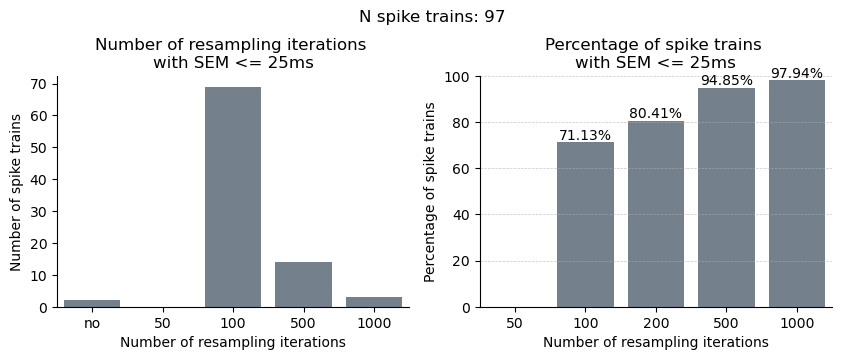

In [66]:
fig, axes = plt.subplots(1,2,figsize=(10,3))

sns.barplot(ax=axes[0], x='stabilization_point', y='unit_id', data=stab_point_count_df_sorted, color='slategray')
axes[0].set_title('Number of resampling iterations \nwith SEM <= 25ms')
axes[0].set_ylabel('Number of spike trains')

sns.barplot(ax=axes[1], x='m_iterations', y='n_signals_below_perc', data=stab_below_df, color='slategray')
labels = [str(np.round(v, 2)) + '%' if v else '' for v in axes[1].containers[0].datavalues]
axes[1].bar_label(axes[1].containers[0], labels=labels)
axes[1].set_title('Percentage of spike trains \nwith SEM <= 25ms')
axes[1].set_ylabel('Percentage of spike trains')
axes[1].set_ylim([0, 100])
axes[1].grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)

fig.suptitle(f'N spike trains: {len(stabilization_df)}', y=1.1)

for ax in axes.flat:
     ax.set_xlabel('Number of resampling iterations')

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'stab_points.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'stab_points.svg' , bbox_inches='tight')

##### Plot per brain area 

In [43]:
def get_area(area_name):
    stabilization_df_area = stabilization_df.query('ecephys_structure_acronym == @area_name')
    n_signals = len(stabilization_df_area)
    n_signals_below_l = []
    for n_iterations in m_iterations_x_axes:
        n_signals_below = len(stabilization_df_area.query('stabilization_point <= @n_iterations'))
        n_signals_below_l.append(n_signals_below/n_signals * 100)
    
    stab_below_df = pd.DataFrame({
        "m_iterations": m_iterations_x_axes,
        "n_signals_below_perc": n_signals_below_l
    })
    return stab_below_df

In [44]:
areas = stabilization_df['ecephys_structure_acronym'].unique()
print(areas)

['VISam' 'LP' 'LGd' 'VISal' 'VISp' 'VISl' 'VISpm' 'VISrl']


In [46]:
stabilization_df_area = get_area(areas[1])
stabilization_df_area

,m_iterations,n_signals_below_perc
0,50,0.000000
1,100,75.000000
2,200,83.333333
3,500,100.000000
4,1000,100.000000


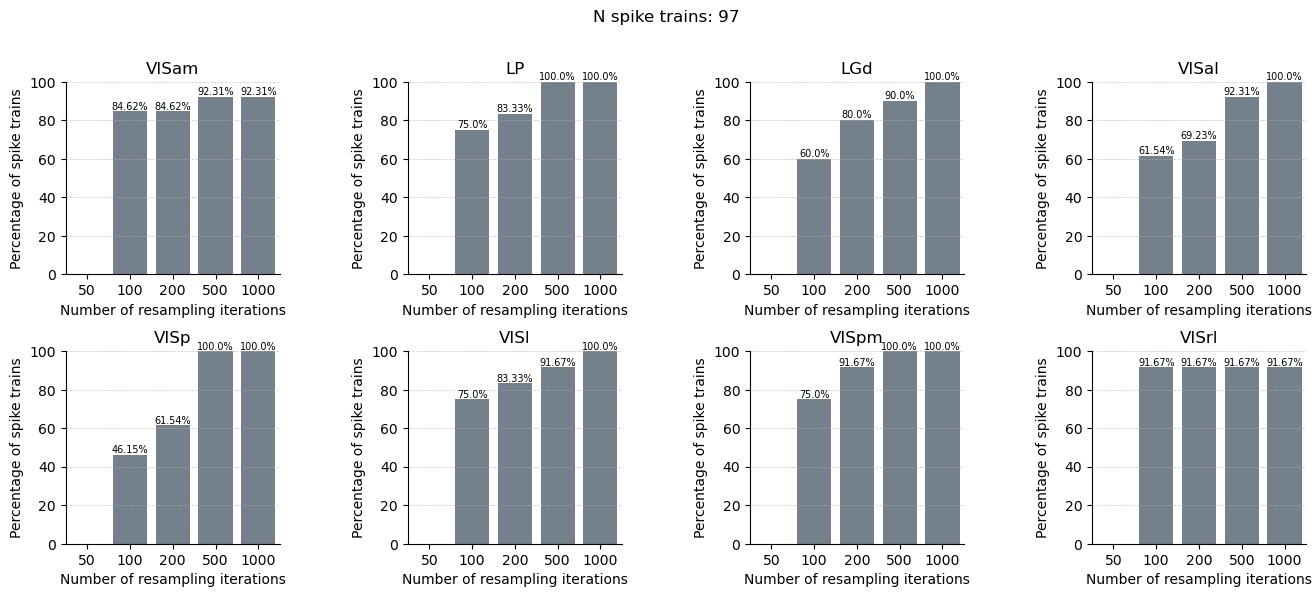

In [67]:
fig, axes = plt.subplots(2,4,figsize=(16,6))
plt.subplots_adjust(hspace=0.4, wspace=0.6)

for i in range(4):
    stabilization_df_area = get_area(areas[i])
    sns.barplot(ax=axes[0,i], x='m_iterations', y='n_signals_below_perc', data=stabilization_df_area, color='slategray')
    labels = [str(np.round(v, 2)) + '%' if v else '' for v in axes[0,i].containers[0].datavalues]
    axes[0,i].bar_label(axes[0, i].containers[0], labels=labels, fontsize=7)
    axes[0,i].set_title(areas[i])

for i in range(4, 8):
    stabilization_df_area = get_area(areas[i])
    sns.barplot(ax=axes[1,i-4], x='m_iterations', y='n_signals_below_perc', data=stabilization_df_area, color='slategray')
    labels = [str(np.round(v, 2)) + '%' if v else '' for v in axes[1,i-4].containers[0].datavalues]
    axes[1,i-4].bar_label(axes[1, i-4].containers[0], labels=labels, fontsize=7)
    axes[1,i-4].set_title(areas[i])

fig.suptitle(f'N spike trains: {len(stabilization_df)}', y=1)

for ax in axes.flat:
    ax.set_xlabel('Number of resampling iterations')
    ax.set_ylabel('Percentage of spike trains')
    ax.set_ylim([0, 100])
    ax.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'stab_points_per_area.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'stab_points_per_area.svg' , bbox_inches='tight')